# Jobs availables in Venezuela

The project was made mainly with the intention to learn two things:

1. Web scraping
2. Simple data analysis and visualization with pandas and matplotlib

As this is a pretty basic and simple project, due to my inexperience with the tools and techniques, so there may be optimizations and improvements to be made.

There are three goals to achieve:

1. Know what states in Venezuela has the most job openings.
2. Know what job categories has the most job openings.
3. Know if there is a relationship between the number of jobs offerings in a state and their population.

The data for the project was gathered via web scraping from the web site Computrabajo, and the population data from Instituto Nacional de Estadistica de Venezuela (Venezuelan National Statistics Institute).





#### Initial setup
First of all, import all the relevant libraries and getting the basic setup for the URLs needed to scrap.


In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import os

HEADERS = {  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Cache-Control": "max-age=0"}

BASE_URL = 'https://ve.computrabajo.com/empleos'

ESTADOS = [
    'aragua', 'distrito-capital', 'carabobo', 'miranda', 'anzoategui',
    'lara', 'nueva-esparta', 'zulia', 'portuguesa', 'trujillo',
    'tachira', 'bolivar', 'monagas', 'merida', 'vargas',
    'falcon', 'barinas', 'yaracuy', 'sucre', 'guarico',
    'delta-amacuro', 'apure', 'cojedes','amazonas'
    ]

CATEGORIAS = [
    'ventas', 'atencion-a-clientes', 'administracion-y-oficina', 'almacen-logistica',
    'otros', 'servicios-generales-aseo-y-seguridad', 'medicina-y-salud', 'callcenter-telemercadeo',
    'economia-y-contabilidad', 'mercadeo-publicidad-comunicacion', 'produccion-operaciones',
    'mantenimiento-y-reparaciones-tecnicas', 'hosteleria-y-turismo', 'recursos-humanos',
    'ingenieria-y-tecnico', 'arte-y-diseno-y-medios','compras-comercio-exterior',
    'educacion-y-universidad', 'construccion-y-obra', 'direccion-y-gerencia',
    'cientifico-y-investigacion', 'legal-y-asesoria'
]

jobs_data_dir = 'jobs_data.csv'


Also import the estimated population for the year 2023 data.

In [3]:
poblacion = pd.read_csv('./poblacion2023.csv')
poblacion['region'] = poblacion['region'].str.capitalize()
poblacion['estado'] = poblacion['estado'].str.capitalize()
poblacion

,region,estado,poblacion proyectada 2023
0,Centro,Distrito capital,2095180
1,Guayana,Amazonas,218438
2,Oriente,Anzoategui,1847222
3,Llanos,Apure,667147
4,Occidente,Aragua,1929193
5,Llanos,Barinas,1007338
6,Guayana,Bolivar,1974310
7,Centro,Carabobo,2631056
8,Occidente,Cojedes,394123
9,Oriente,Delta amacuro,224606


#### Web scraping

The scraped data is the number of job openings each states has for each category:
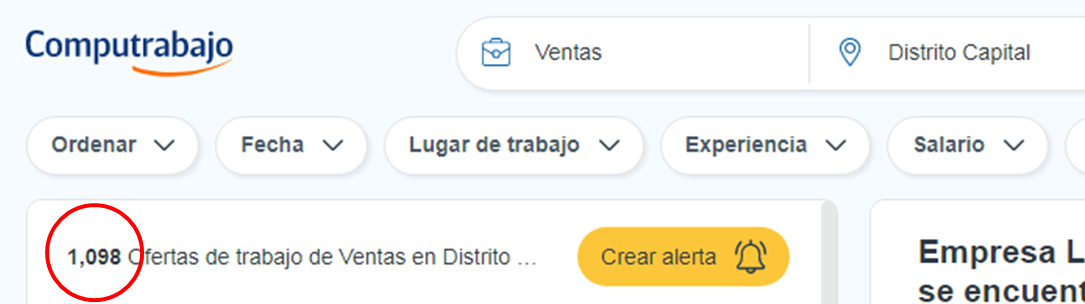

Loop through each job category for each state, saving the scraped data into the 'jobs' list.
As there may be some states that do not have any job openings for a category, to avoid an exception error the value will be 'None'.

In [9]:
# Check if already exists a data file to avoid scraping again

if os.path.exists(f'./{jobs_data_dir}'):
  df = pd.read_csv(f'./{jobs_data_dir}')
  print('File found')

else:
  print('File not found, scraping now...')
  jobs = []

  for estado in ESTADOS[0:1]:
    print(f'Recopilando datos de {estado}')
    for categoria in CATEGORIAS[0:1]:
      # Each row data (state, category and number of job openings)
      new_jobs = {}
      new_jobs['estado']=estado
      new_jobs['categoria']=categoria

      URL = f"{BASE_URL}-de-{categoria}-en-{estado}"
      response = requests.get(URL, headers=HEADERS)
      soup = BeautifulSoup(response.content, 'html.parser')
      try:
        num_jobs = soup.select('span.fwB')[4].getText()
      except:
        num_jobs = None

      new_jobs['num_jobs']=num_jobs

      jobs.append(new_jobs)
      # Waits 5 seconds before scraping next page
      sleep(5)

  df = pd.DataFrame(jobs)
  df.to_csv(jobs_data_dir, index=False)
  print(f'Data scraped and file {jobs_data_dir} saved')


File found


#### Data cleaning

Create a DataFrame to contain all the data for an easier cleaning and then analysis.


In [10]:
# Checking the dataframe
df

,estado,categoria,num_trabajos
0,aragua,ventas,"1,030"
1,aragua,atencion-a-clientes,189
2,aragua,administracion-y-oficina,238
3,aragua,almacen-logistica,159
4,aragua,otros,115
...,...,...,...
523,amazonas,educacion-y-universidad,32
524,amazonas,construccion-y-obra,3
525,amazonas,direccion-y-gerencia,12
526,amazonas,cientifico-y-investigacion,NaN


Most of the data is pretty simple, the cleaning is just:
* Replace all the None values to zero (0).
* Replacing all the '-' to blank spaces for better readability.
* Convert the 'num_trabajos' columns from string to int.
* Capitalize the data

In [11]:
# Replace None values
df_clean = df.fillna(0)

# Replace -
df_clean.replace('-',' ', regex=True, inplace=True)

# Convert data into INT
df_clean['num_trabajos'].replace(',','', regex=True, inplace=True)
df_clean = df_clean.astype({'num_trabajos': 'int'})
df_clean['estado'] = df_clean['estado'].str.capitalize()
df_clean['categoria'] = df_clean['categoria'].str.capitalize()
df_clean

,estado,categoria,num_trabajos
0,Aragua,Ventas,1030
1,Aragua,Atencion a clientes,189
2,Aragua,Administracion y oficina,238
3,Aragua,Almacen logistica,159
4,Aragua,Otros,115
...,...,...,...
523,Amazonas,Educacion y universidad,32
524,Amazonas,Construccion y obra,3
525,Amazonas,Direccion y gerencia,12
526,Amazonas,Cientifico y investigacion,0


#### Analysis

First, two new dataframes are created:

* To summarize the number of job openings per state.
* Another to summarize the number of job openings per category.

In [12]:
res_estado = df_clean.groupby('estado').sum()
res_estado

<ipython-input-12-4fc5d0341bb1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_estado = df_clean.groupby('estado').sum()


,num_trabajos
estado,
Amazonas,762
Anzoategui,1529
Apure,775
Aragua,2754
Barinas,884
Bolivar,1080
Carabobo,3344
Cojedes,784
Delta amacuro,760


In [13]:
res_categoria = df_clean.groupby('categoria').sum()
res_categoria

<ipython-input-13-63f907244608>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_categoria = df_clean.groupby('categoria').sum()


,num_trabajos
categoria,
Administracion y oficina,2456
Almacen logistica,1264
Arte y diseno y medios,1103
Atencion a clientes,4654
Callcenter telemercadeo,2296
Cientifico y investigacion,72
Compras comercio exterior,241
Construccion y obra,215
Direccion y gerencia,386


For the relationship analysis, a new data frame is created by merging the job openings per state and the population per state data frames.

In [14]:
merged = poblacion.merge(res_estado, left_on='estado', right_on='estado')
merged

,region,estado,poblacion proyectada 2023,num_trabajos
0,Centro,Distrito capital,2095180,7077
1,Guayana,Amazonas,218438,762
2,Oriente,Anzoategui,1847222,1529
3,Llanos,Apure,667147,775
4,Occidente,Aragua,1929193,2754
5,Llanos,Barinas,1007338,884
6,Guayana,Bolivar,1974310,1080
7,Centro,Carabobo,2631056,3344
8,Occidente,Cojedes,394123,784
9,Oriente,Delta amacuro,224606,760


##### Charts

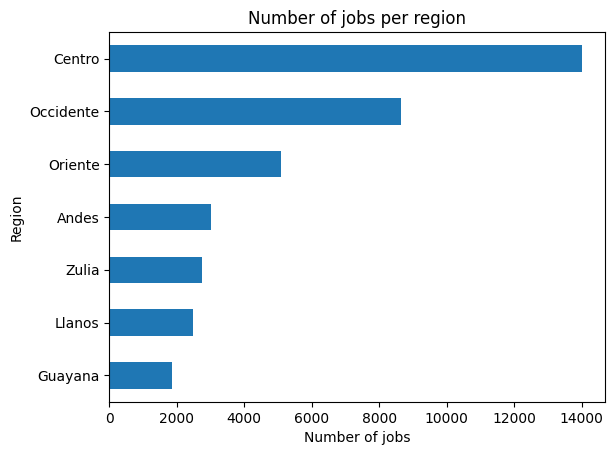

In [15]:
res_region = merged[['region', 'num_trabajos']].groupby('region').sum()
res_region.sort_values('num_trabajos').plot.barh(
    title='Number of jobs per region',
    ylabel='Region',
    xlabel='Number of jobs',
    legend=False
)
plt.show()

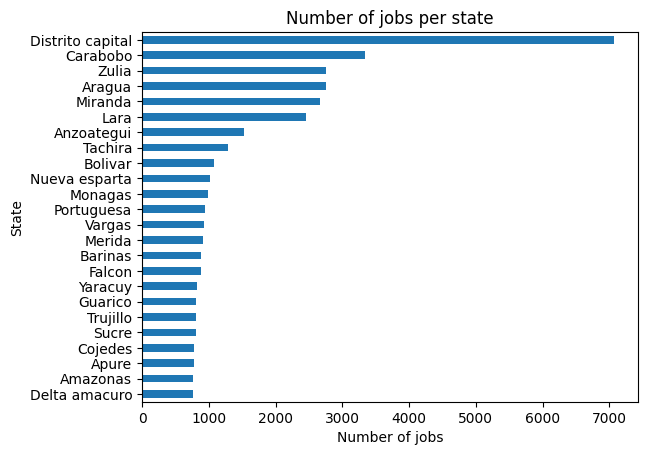

In [17]:

res_estado.sort_values(by=['num_trabajos']).plot.barh(
    title='Number of jobs per state',
    ylabel='State',
    xlabel='Number of jobs',
    legend=False)
plt.show()


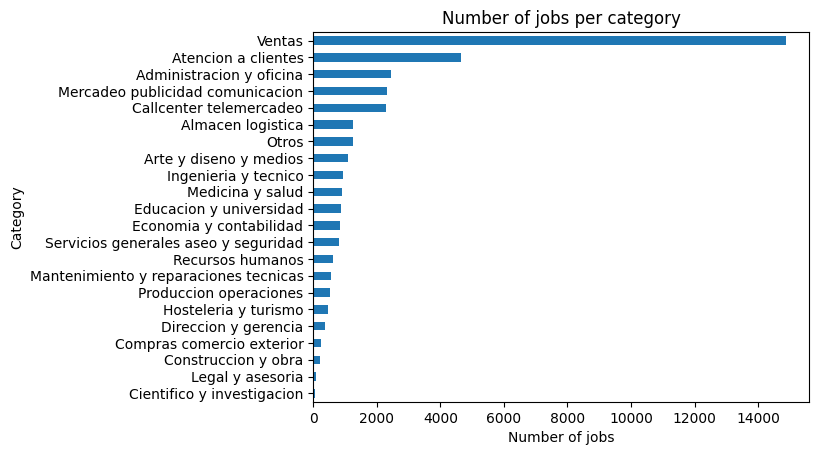

In [18]:
res_categoria.sort_values(by=['num_trabajos']).plot.barh(
    title='Number of jobs per category',
    ylabel='Category',
    xlabel='Number of jobs',
    legend=False)
plt.show()

The bar chart above clearly shows that the vast majority of job openings in Computrabajo are sales related (ventas), being a percentage of the total:

In [19]:
num_sales_jobs = res_categoria.at['Ventas', 'num_trabajos']
num_total_jobs = res_categoria['num_trabajos'].sum()
print(f"Percentage of sales jobs: {round((num_sales_jobs/num_total_jobs)*100, 2)}%")


Percentage of sales jobs: 39.29%


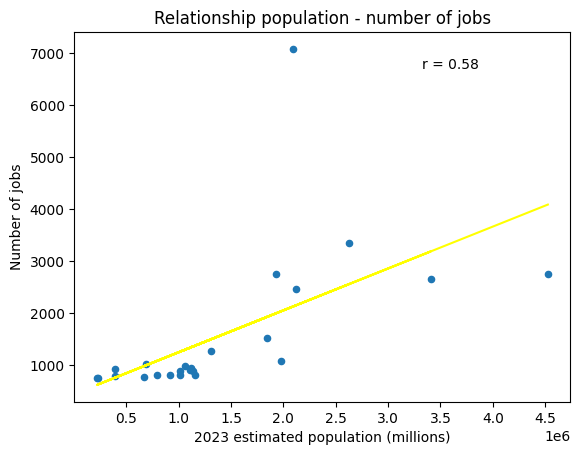

In [20]:
merged.plot.scatter(x='poblacion proyectada 2023',
                    y='num_trabajos',
                    xlabel='2023 estimated population (millions)',
                    ylabel='Number of jobs',
                    title='Relationship population - number of jobs',
                    xticks=range(0,5000000,500000)
                  )
# Regression line
m,b = np.polyfit(merged['poblacion proyectada 2023'], merged['num_trabajos'], 1)

# Correlation
r = np.corrcoef(merged['poblacion proyectada 2023'], merged['num_trabajos'])[0,1]
plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

plt.plot(merged['poblacion proyectada 2023'], m*merged['poblacion proyectada 2023']+b, color='yellow')
plt.show()

We can see above that there is a slight correlation between the states population and the number of jobs openings, specially in the states with lower population

Now, if we exclude those extreme values (from distrito capital) the results are like:

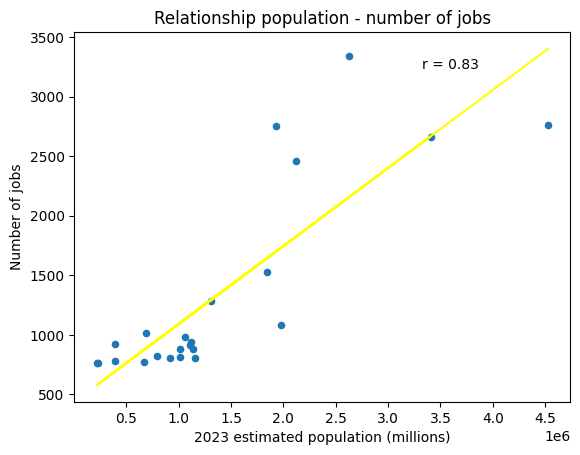

In [21]:
without_extremes = merged[merged['estado'] != 'Distrito capital']

without_extremes.plot.scatter(x='poblacion proyectada 2023',
                    y='num_trabajos',
                    xlabel='2023 estimated population (millions)',
                    ylabel='Number of jobs',
                    title='Relationship population - number of jobs',
                    xticks=range(0,5000000,500000)
                  )
# Regression line
m,b = np.polyfit(without_extremes['poblacion proyectada 2023'],
                 without_extremes['num_trabajos'], 1)

# Correlation
r = np.corrcoef(without_extremes['poblacion proyectada 2023'],
                without_extremes['num_trabajos'])[0,1]

plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

plt.plot(without_extremes['poblacion proyectada 2023'],
         m*without_extremes['poblacion proyectada 2023']+b,
         color='yellow')
plt.show()